# SparK: A Visualization Demo
A demo using our pretrained SparK model to reconstruct masked images.
The mask is whether specified by the user or randomly generated.

**NOTE:** if you want to visualize your own pretrained model, you may need to modify the `IMAGENET_RGB_MEAN` and `IMAGENET_RGB_STD` below to your numbers. In Step 5, use `spark, input_size = build_spark('_withdecoder_1kpretrained_spark_style.pth')` to load your model.

## 1. Preparation
Install dependencies, specify the device, and specify the pretrained model.

In [1]:
# install dependencies
import sys
if 'google.colab' in sys.modules:
    !pip3 install -r requirements.txt

# specify the device to use
USING_GPU_IF_AVAILABLE = True

import torch
_ = torch.empty(1)
if torch.cuda.is_available() and USING_GPU_IF_AVAILABLE:
    _ = _.cuda()
DEVICE = _.device
print(f'[DEVICE={DEVICE}]')


[DEVICE=cuda:0]


## 2. Define utils: load data

In [2]:
from PIL import Image
import torchvision.transforms.functional as TF
IMAGENET_RGB_MEAN = torch.tensor((0.485, 0.456, 0.406), device=DEVICE).reshape(1, 3, 1, 1)
IMAGENET_RGB_STD = torch.tensor((0.229, 0.224, 0.225), device=DEVICE).reshape(1, 3, 1, 1)
def load_image(size: int, img_file: str):
    img = Image.open(img_file).convert('RGB')
    img = TF.center_crop(TF.resize(img, size), [size, size])
    img = TF.to_tensor(img).unsqueeze(0).to(DEVICE).sub(IMAGENET_RGB_MEAN).div_(IMAGENET_RGB_STD)
    return img
def denormalize(img_bchw):
    return img_bchw.mul(IMAGENET_RGB_STD).add_(IMAGENET_RGB_MEAN).clamp_(0., 1.)

## 3. Define utils: build a SparK model

In [3]:
import os
from decoder import LightDecoder
from encoder import SparseEncoder
from models import build_sparse_encoder
from spark import SparK
def build_spark(your_own_pretrained_ckpt: str = ''):
    if len(your_own_pretrained_ckpt) > 0 and os.path.exists(your_own_pretrained_ckpt):
        all_state = torch.load(your_own_pretrained_ckpt, map_location='cpu')
        input_size, model_name = all_state['input_size'], all_state['arch']
        pretrained_state = all_state['module']
        print(f"[in function `build_spark`] your ckpt `{your_own_pretrained_ckpt}` loaded;  don't forget to modify IMAGENET_RGB_MEAN and IMAGENET_RGB_MEAN above if needed")
    else:
        # download and load the checkpoint
        input_size, model_name, file_path, ckpt_link = {
            'ResNet50': (224, 'resnet50', 'res50_withdecoder_1kpretrained_spark_style.pth', 'https://drive.google.com/file/d/1STt3w3e5q9eCPZa8VzcJj1zG6p3jLeSF/view?usp=share_link'),
            'ResNet101': (224, 'resnet101', 'res101_withdecoder_1kpretrained_spark_style.pth', 'https://drive.google.com/file/d/1GjN48LKtlop2YQre6---7ViCWO-3C0yr/view?usp=share_link'),
            'ResNet152': (224, 'resnet152', 'res152_withdecoder_1kpretrained_spark_style.pth', 'https://drive.google.com/file/d/1U3Cd94j4ZHfYR2dUjWmsEWfjP6Opx4oo/view?usp=share_link'),
            'ResNet200': (224, 'resnet200', 'res200_withdecoder_1kpretrained_spark_style.pth', 'https://drive.google.com/file/d/13AFSqvIr0v-2hmb4DzVza45t_lhf2CnD/view?usp=share_link'),
            'ConvNeXt-S': (224, 'convnext_small', 'cnxS224_withdecoder_1kpretrained_spark_style.pth', 'https://drive.google.com/file/d/1bKvrE4sNq1PfzhWlQJXEPrl2kHqHRZM-/view?usp=share_link'),
            'ConvNeXt-L': (384, 'convnext_large', 'cnxL384_withdecoder_1kpretrained_spark_style.pth', 'https://drive.google.com/file/d/1ZI9Jgtb3fKWE_vDFEly29w-1FWZSNwa0/view?usp=share_link')
        }['ConvNeXt-L']  # you can choose any model here
        assert os.path.exists(file_path), f'please download checkpoint {file_path} from {ckpt_link}'
        pretrained_state = torch.load(file_path, map_location='cpu')
        if 'module' in pretrained_state:
            pretrained_state = pretrained_state['module']

    # build a SparK model
    config = pretrained_state['config']
    enc: SparseEncoder = build_sparse_encoder(model_name, input_size=input_size)
    spark = SparK(
        sparse_encoder=enc, dense_decoder=LightDecoder(enc.downsample_raito, sbn=False),
        mask_ratio=config['mask_ratio'], densify_norm=config['densify_norm_str'], sbn=config['sbn'],
    ).to(DEVICE)
    spark.eval(), [p.requires_grad_(False) for p in spark.parameters()]
    
    # load the checkpoint
    missing, unexpected = spark.load_state_dict(pretrained_state, strict=False)
    assert len(missing) == 0, f'load_state_dict missing keys: {missing}'
    assert len(unexpected) == 0, f'load_state_dict unexpected keys: {unexpected}'
    del pretrained_state
    return spark, input_size


## 4. Define utils: visualize

In [4]:
import matplotlib.pyplot as plt
def show(spark: SparK, size: int, img_file='viz_imgs/recon.png', active_b1ff: torch.BoolTensor = None):
    inp_bchw = load_image(size, img_file)
    spark.forward
    inp_bchw, masked_bchw, rec_or_inp = spark(inp_bchw, active_b1ff=active_b1ff, vis=True)
    # plot these three images in a row
    masked_title = 'rand masked' if active_b1ff is None else 'specified masked'
    for col, (title, bchw) in enumerate(zip(['input', masked_title, 'reconstructed'], [inp_bchw, masked_bchw, rec_or_inp])):
        plt.subplot2grid((1, 3), (0, col))
        plt.imshow(denormalize(bchw)[0].permute(1, 2, 0).cpu().numpy())
        plt.title(title)
        plt.axis('off')
    plt.show()

## 5. Run SparK with a specified mask

In [ ]:
spark, input_size = build_spark()
# for visualizing your own pretrained model of '<model_name>_withdecoder_1kpretrained_spark_style.pth', run:
# spark, input_size = build_spark('<model_name>_withdecoder_1kpretrained_spark_style.pth')

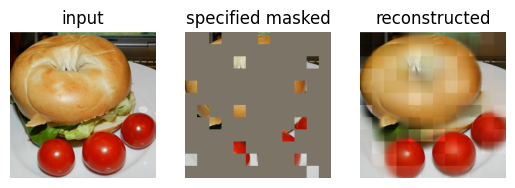

In [6]:
# specify the mask
if input_size == 384:
    active_b1ff = torch.tensor([
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    ], device=DEVICE).bool().reshape(1, 1, 12, 12)
elif input_size == 224:
    active_b1ff = torch.tensor([
        [0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0],
    ], device=DEVICE).bool().reshape(1, 1, 7, 7)
else:
    raise NotImplementedError('define your mask for other input_size')

show(spark, input_size, 'viz_imgs/recon.png', active_b1ff=active_b1ff)

## 6. Run SparK with a random mask

In [ ]:
# use a random mask (don't specify the mask)
show(spark, input_size, 'viz_imgs/recon.png', active_b1ff=None)